In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

In [2]:
plt.rcParams["figure.facecolor"] = "w"

sns.set_style('whitegrid')

#### Иллюстрация про ошибки оценки

In [3]:
users_num = 1000

mean_user_ctr = 0.2
beta = 20
alpha = mean_user_ctr * beta / (1 - mean_user_ctr)

user_ctr = np.random.beta(alpha, beta, size=users_num)

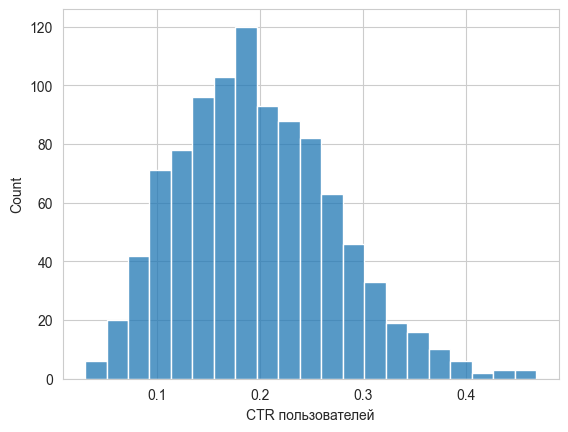

In [4]:
sns.histplot(user_ctr)
plt.xlabel('CTR пользователей')
plt.show()

In [5]:
views = np.random.lognormal(mean=1, sigma=1, size=users_num).astype(int) + 1

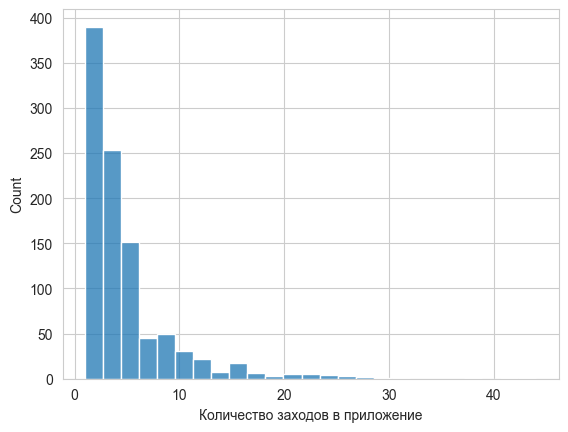

In [6]:
sns.histplot(views, bins=25)
plt.xlabel('Количество заходов в приложение')
plt.show()

In [7]:
clicks = np.random.binomial(views, user_ctr)

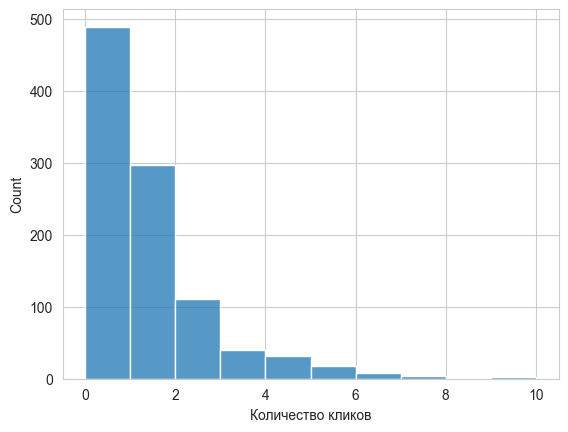

In [8]:
sns.histplot(clicks, bins=10)
plt.xlabel('Количество кликов')
plt.show()

Оценим по кликам

In [9]:
users_num = 1000

mean_user_ctr = 0.2
beta = 20
alpha = mean_user_ctr * beta / (1 - mean_user_ctr)

In [10]:
def get_pvalue():
    user_ctr = np.random.beta(alpha, beta, size=users_num)
    views = np.random.lognormal(mean=1, sigma=1, size=users_num).astype(int) + 1
    clicks = np.random.binomial(views, user_ctr)

    mask = np.random.rand(len(views)) < 0.5
    views_1, clicks_1 = views[mask], clicks[mask]
    views_2, clicks_2 = views[~mask], clicks[~mask]

    return mannwhitneyu(clicks_1, clicks_2)[1]

In [11]:
pvalues = [get_pvalue() for _ in range(10000)]

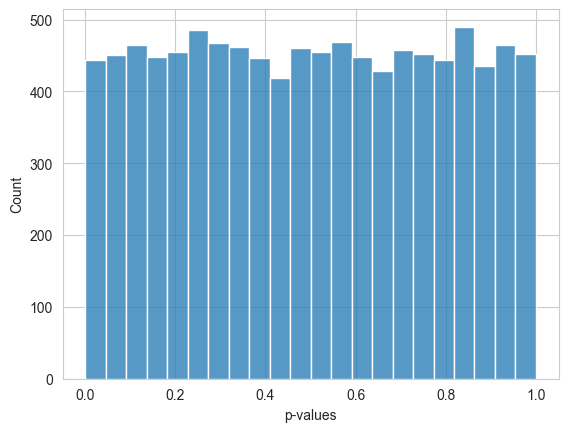

In [12]:
sns.histplot(pvalues)
plt.xlabel('p-values')
plt.show()

In [13]:
np.mean(np.array(pvalues) < 0.05)

0.0509

Подглядывание в результат

In [14]:
users_num = 1000

mean_user_ctr = 0.2
beta = 20
alpha = mean_user_ctr * beta / (1 - mean_user_ctr)

n_days = 7

In [15]:
def get_pvalue():
    users_num_day, current_pvalue = round(users_num / n_days), 1
    views, clicks, mask = np.array([]), np.array([]), np.array([])
    
    for day in range(n_days):
        user_ctr_day = np.random.beta(alpha, beta, size=users_num_day)
        views_day = np.random.lognormal(
            mean=1, sigma=1, size=users_num_day
        ).astype(int) + 1
        clicks_day = np.random.binomial(views_day, user_ctr_day)
        mask_day = np.random.rand(len(views_day)) < 0.5
        
        views = np.concatenate((views, views_day))
        clicks = np.concatenate((clicks, clicks_day))
        mask = np.concatenate((mask, mask_day)).astype(bool)
        views_1, clicks_1 = views[mask], clicks[mask]
        views_2, clicks_2 = views[~mask], clicks[~mask]
        
        current_pvalue = min(current_pvalue, mannwhitneyu(clicks_1, clicks_2)[1])

    return current_pvalue

In [16]:
pvalues = [get_pvalue() for _ in range(10000)]

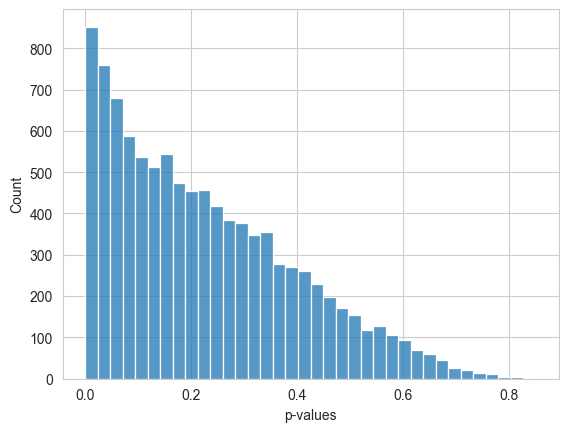

In [17]:
sns.histplot(pvalues)
plt.xlabel('p-values')
plt.show()

In [18]:
np.mean(np.array(pvalues) < 0.05)

0.1707

#### Нерепрезентативный период

In [19]:
metrics = np.hstack((
    np.random.normal(15, 1, 4 * 5).reshape((-1, 4)),
    np.random.normal(18, 1, 1 * 5).reshape((-1, 1)),
    np.random.normal(22, 1, 2 * 5).reshape((-1, 2)),))

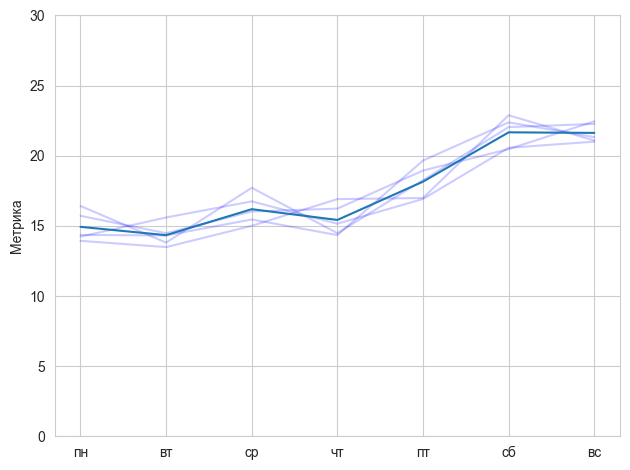

In [20]:
for i in range(len(metrics)):
    plt.plot(metrics[i], alpha=0.2, color='blue')
    
plt.plot(metrics.mean(axis=0))
plt.ylim(bottom=0, top=30)
plt.xticks(range(7), ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'])
plt.ylabel('Метрика')
plt.tight_layout()
plt.savefig('week_metrics.pdf')
plt.show()

#### Ошибка с ложными прокрасками

In [21]:
def get_pvalue(): 
    user_ctr = np.random.beta(alpha, beta, size=users_num)
    views = np.random.lognormal(mean=1, sigma=1, size=users_num).astype(int) + 1
    clicks = np.random.binomial(views, user_ctr)

    mask = np.random.rand(len(views)) < 0.5
    views_1, clicks_1 = views[mask], clicks[mask]
    views_2, clicks_2 = views[~mask], clicks[~mask]
    
    sessions_1 = []
    for v, c in zip(views_1, clicks_1):
        sessions_1 += [1] * c + [0] * (v - c) 

    sessions_2 = []
    for v, c in zip(views_2, clicks_2):
        sessions_2 += [1] * c + [0] * (v - c) 
        
    return proportions_ztest(
        count=[sum(sessions_1), sum(sessions_2)],
        nobs=[len(sessions_1), len(sessions_2)]
    )[1]

In [22]:
pvalues = [get_pvalue() for _ in range(10000)]

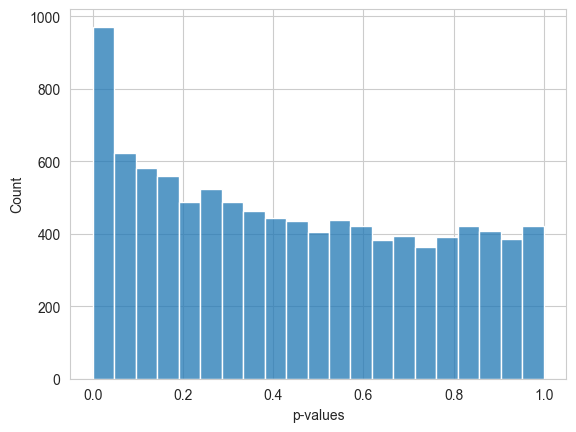

In [23]:
sns.histplot(pvalues)
plt.xlabel('p-values')
plt.show()

In [24]:
np.mean(np.array(pvalues) < 0.05)

0.1006